In [2]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
#import gurobipy as gp
#from pyomo.environ import *

In [7]:
import requests
import pandas as pd
from requests.adapters import HTTPAdapter, Retry

BASE_URL = "https://services9.arcgis.com/xSsJeibXqRtsnmY7/arcgis/rest/services/Hydrogen_Infrastructure_Map_2024Q4_WFL1/FeatureServer"


# --- Robust HTTP client ---
session = requests.Session()
retries = Retry(total=5, backoff_factor=0.5, status_forcelist=[429, 500, 502, 503, 504])
session.mount("https://", HTTPAdapter(max_retries=retries))

def fetch_json(url, params=None, timeout=30):
    r = session.get(url, params=params, timeout=timeout)
    r.raise_for_status()
    data = r.json()
    if "error" in data:
        raise RuntimeError(data["error"])
    return data

def get_service_metadata():
    return fetch_json(BASE_URL, params={"f": "json"})

def iter_features(layer_id, out_fields="*", where="1=1", include_geometry=True, out_sr=4326, page_size=2000):
    url = f"{BASE_URL}/{layer_id}/query"
    params = {
        "f": "json",
        "where": where,
        "outFields": out_fields,
        "returnGeometry": "true" if include_geometry else "false",
        "outSR": str(out_sr),
        "resultOffset": 0,
        "resultRecordCount": page_size,
    }
    while True:
        data = fetch_json(url, params=params)
        feats = data.get("features", [])
        for feat in feats:
            yield feat
        if not data.get("exceededTransferLimit"):
            break
        params["resultOffset"] += params["resultRecordCount"]

def arcgis_date_fields(layer_dict):
    return {f["name"] for f in layer_dict.get("fields", []) if f.get("type") == "esriFieldTypeDate"}

def collect_all_layers(out_fields="*", where="1=1", include_geometry=True):
    meta = get_service_metadata()
    layers = meta.get("layers", [])
    print(f"Found {len(layers)} layers.")

    rows = []
    all_date_cols = set()

    for layer in layers:
        lid, lname = layer["id"], layer["name"]
        date_cols = arcgis_date_fields(layer)
        all_date_cols |= date_cols

        print(f"\nLayer ID: {lid} - {lname}")
        count = 0
        for feat in iter_features(lid, out_fields=out_fields, where=where, include_geometry=include_geometry, out_sr=4326):
            attrs = dict(feat.get("attributes", {}))  # copy
            if include_geometry and "geometry" in feat:
                attrs["geometry"] = feat["geometry"]  # raw Esri geometry dict
            attrs["_layer_id"] = lid
            attrs["_layer_name"] = lname
            rows.append(attrs)
            count += 1
        print(f"Collected {count} feature(s) from this layer.")

    df = pd.DataFrame(rows)

    # Convert any ArcGIS date fields (epoch ms) that actually appear
    for col in all_date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], unit="ms", errors="coerce")

    return df

if __name__ == "__main__":
    # Tip: narrow fields (e.g. "OBJECTID,Category,Project_Na,Project_Ty,Promoter_N") to reduce payload
    all_layer_data_df = collect_all_layers(out_fields="*", where="1=1", include_geometry=True)
    print(f"\nTotal number of features collected: {len(all_layer_data_df)}")
    #print(all_layer_data_df.head())

all_layer_data_df.head()

Found 8 layers.

Layer ID: 0 - Distribution
Collected 52 feature(s) from this layer.

Layer ID: 1 - Demand And Production
Collected 280 feature(s) from this layer.

Layer ID: 2 - Terminals And Ports
Collected 32 feature(s) from this layer.

Layer ID: 3 - Storage
Collected 80 feature(s) from this layer.

Layer ID: 4 - Capitals
Collected 31 feature(s) from this layer.

Layer ID: 5 - BigCities
Collected 48 feature(s) from this layer.

Layer ID: 6 - High Pressure Distribution
Collected 26 feature(s) from this layer.

Layer ID: 7 - Transmission
Collected 241 feature(s) from this layer.

Total number of features collected: 790


,OBJECTID,Project_Na,Promoter_N,Project_Ty,Category,Commission,Share_of_t,Location,Increment,Peak_Incre,...,Daily_Send_out_capacity__GWh,Total_storage_capacity__GWh,Maturity_S,Operation,Storage_Ty,Storage_wo,Injection,Withdrawal,NAME,Shape__Length
0,1,Beimischung Teilnetz Coesfeld,Gelsenwasser Energienetze GmbH,Conversion of existing infrastructure,Distribution,2023,10,Coesfeld,No data available,No data available,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Energiepark Mainz,Mainzer Stadtwerke AG,Mix,Distribution,Unknown,100 (10 for some customers),Mainz,No data available,No data available,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,enerPort II,Netze Duisburg GmbH,Mix,Distribution,2023,100,Duisburg,No data available,No data available,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Farma Hranice,"GasNet, s.r.o.",Conversion of existing infrastructure,Distribution,2024,up to 20,Czech Republic / As,No data available,No data available,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Geesthachter Wasserstoff Hafen,Stadt Geesthacht,Mix,Distribution,2025,100,Geesthacht,No data available,No data available,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
all_layer_data_df.Category.unique()
all_layer_data_df._layer_name.unique()

array(['Distribution', 'Demand And Production', 'Terminals And Ports',
       'Storage', 'Capitals', 'BigCities', 'High Pressure Distribution',
       'Transmission'], dtype=object)

In [65]:
all_layer_data_df.to_clipboard()

In [10]:
all_layer_data_df.fillna("unknown", inplace=True)
pipelines_df = all_layer_data_df[(all_layer_data_df.Category.str.contains('|Transmissioin|Transmission|Distribution'))]
mask_geom = all_layer_data_df["geometry"].astype(str).str.contains("paths", case=False, na=False)
pipelines_df = all_layer_data_df.loc[mask_geom].copy()
pipelines_df.head()#.to_clipboard()

,OBJECTID,Project_Na,Promoter_N,Project_Ty,Category,Commission,Share_of_t,Location,Increment,Peak_Incre,...,Daily_Send_out_capacity__GWh,Total_storage_capacity__GWh,Maturity_S,Operation,Storage_Ty,Storage_wo,Injection,Withdrawal,NAME,Shape__Length
523,1,Feasibility study South Jutland,Evida,New,Distribution,2026,100,Denmark/South Jutland between Esbjerg and Fred...,No data available,No data available,...,unknown,unknown,Less-Advanced,unknown,unknown,unknown,unknown,unknown,unknown,159115.534958
524,2,Feasibility study South Jutland,Evida,New,Distribution,2026,100,Denmark/South Jutland between Esbjerg and Fred...,No data available,No data available,...,unknown,unknown,Less-Advanced,unknown,unknown,unknown,unknown,unknown,unknown,109340.315027
525,3,Feasibility study South Jutland,Evida,New,Distribution,2026,100,Denmark/South Jutland between Esbjerg and Fred...,No data available,No data available,...,unknown,unknown,Less-Advanced,unknown,unknown,unknown,unknown,unknown,unknown,198839.617035
526,4,Energieregion Stassfurt,"Energie Mittelsachsen GmbH, MVV Umwelt GmbH, S...",New,Distribution,2025,100,Stassfurt,No data available,No data available,...,unknown,unknown,Advanced (commissioning before 31 Dec 2030),unknown,unknown,unknown,unknown,unknown,unknown,12587.027224
527,5,H2 Collector,AGGM Austrian Gas Grid Management AG,Mix,Distribution,2026,100,Distribution Austria,No data available,No data available,...,unknown,unknown,Less-Advanced,unknown,unknown,unknown,unknown,unknown,unknown,75507.616104


In [11]:
pipelines_df.columns

Index(['OBJECTID', 'Project_Na', 'Promoter_N', 'Project_Ty', 'Category',
       'Commission', 'Share_of_t', 'Location', 'Increment', 'Peak_Incre',
       'Descriptio', 'Website', 'PCI_PMI', 'geometry', '_layer_id',
       '_layer_name', 'Project_Name', 'Promoter_Name', 'Project_Type',
       'Production_category', 'End_use_category', 'Commissioning_Year_First',
       'Share_of_Hydrogen', 'Carrier_Type', 'Capacity__MW',
       'Expected_carrier_yearly_volume_', 'Description', 'No_PCI_PMI',
       'Maturity_Status', 'Share_of_transported_Hydrogen', 'Hydrogen_Derivate',
       'Expected_yearly_volume__GWh_yea', 'Daily_Send_out_capacity__GWh',
       'Total_storage_capacity__GWh', 'Maturity_S', 'Operation', 'Storage_Ty',
       'Storage_wo', 'Injection', 'Withdrawal', 'NAME', 'Shape__Length'],
      dtype='object')

In [12]:
pipelines_df = pipelines_df[['OBJECTID', 'Project_Na', 'Commission', 'Peak_Incre', 'geometry']]
#print(pipelines_df.geometry)
pipelines_df.head()

,OBJECTID,Project_Na,Commission,Peak_Incre,geometry
523,1,Feasibility study South Jutland,2026,No data available,"{'paths': [[[8.44680880785887, 55.468407206064..."
524,2,Feasibility study South Jutland,2026,No data available,"{'paths': [[[9.42732581588392, 56.643368478148..."
525,3,Feasibility study South Jutland,2026,No data available,"{'paths': [[[8.53781414334089, 56.357338636819..."
526,4,Energieregion Stassfurt,2025,No data available,"{'paths': [[[11.6903166441812, 51.895627451088..."
527,5,H2 Collector,2026,No data available,"{'paths': [[[16.4734845857048, 48.166454135977..."


# sparce the pipelines geometry to correct form

In [13]:
import json, ast, re, geopandas as gpd
from shapely.geometry import LineString, MultiLineString
from shapely import wkt

def to_geom(val):
    # already shapely?
    if hasattr(val, "geom_type"): return val

    # WKT
    if isinstance(val, str) and re.match(r'^\s*(MULTI)?LINESTRING', val, re.I):
        try: return wkt.loads(val)
        except: return None

    # Try JSON / python literal
    g = val
    if isinstance(g, str):
        s = g.strip()
        try: g = json.loads(s)
        except:
            try: g = ast.literal_eval(s)
            except: return None

    # GeoJSON LineString/MultiLineString
    if isinstance(g, dict) and "type" in g:
        if g["type"].lower() == "linestring":
            coords = [(x, y) for x, y, *rest in g.get("coordinates", [])]
            return LineString(coords) if len(coords) >= 2 else None
        if g["type"].lower() == "multilinestring":
            lines = []
            for seg in g.get("coordinates", []):
                coords = [(x, y) for x, y, *rest in seg]
                if len(coords) >= 2: lines.append(LineString(coords))
            return MultiLineString(lines) if lines else None

    # ESRI polyline {"paths": [[[x,y],...], ...]}
    if isinstance(g, dict):
        paths = g.get("paths") or g.get("Paths") or g.get("PATHS")
        if paths:
            lines = []
            for path in paths:
                coords = [(x, y) for x, y, *rest in path if path]
                if len(coords) >= 2: lines.append(LineString(coords))
            if not lines: return None
            return lines[0] if len(lines) == 1 else MultiLineString(lines)

    return None

# Build GeoDataFrame from the detected geometry column
GEOM_COL = "geometry"          # <- change to the actual column name you found
df2 = pipelines_df.copy()
df2["geometry"] = df2[GEOM_COL].apply(to_geom)
gdf = gpd.GeoDataFrame(df2[df2["geometry"].notna()].copy(), geometry="geometry", crs="EPSG:4326")
print("Parsed features:", len(gdf))


Parsed features: 265


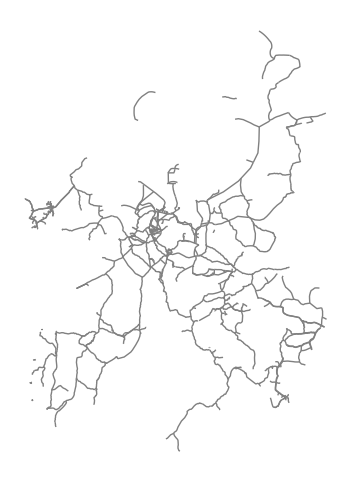

In [23]:
import matplotlib.pyplot as plt

# ensure CRS (looks like lon/lat)
if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4326")

ax = gdf.plot(figsize=(6,6), linewidth=1, color="grey", edgecolor="tab:blue")
ax.set_axis_off()
plt.show()


## DE shape file

In [17]:
import geopandas as gpd
shpfile = r'C:\Users\mun93\Downloads\NUTS_RG_20M_2024_4326.shp\NUTS_RG_20M_2024_4326.shp'
DE_shape_file = gpd.read_file(shpfile)
DE_shape_file = DE_shape_file[(DE_shape_file.NUTS_ID.str.contains('DE')) & (DE_shape_file.LEVL_CODE==2)]
DE_shape_file.head()

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
918,DE11,2,DE,Stuttgart,Stuttgart,NaN,NaN,NaN,"POLYGON ((9.79842 49.69492, 9.93554 49.5007, 1..."
919,DE12,2,DE,Karlsruhe,Karlsruhe,NaN,NaN,NaN,"POLYGON ((9.51528 49.47577, 9.60382 49.42658, ..."
920,DE13,2,DE,Freiburg,Freiburg,NaN,NaN,NaN,"POLYGON ((8.25952 48.38014, 8.30399 48.34909, ..."
921,DE14,2,DE,Tübingen,Tübingen,NaN,NaN,NaN,"POLYGON ((9.94407 48.63176, 10.23078 48.51051,..."
922,DE21,2,DE,Oberbayern,Oberbayern,NaN,NaN,NaN,"POLYGON ((11.51417 49.0465, 11.59931 48.9515, ..."


<Axes: >

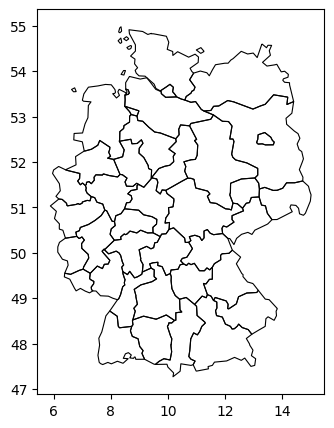

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))
DE_shape_file.plot(ax=ax, color='none', edgecolor='black', linewidth=0.8)


<Axes: >

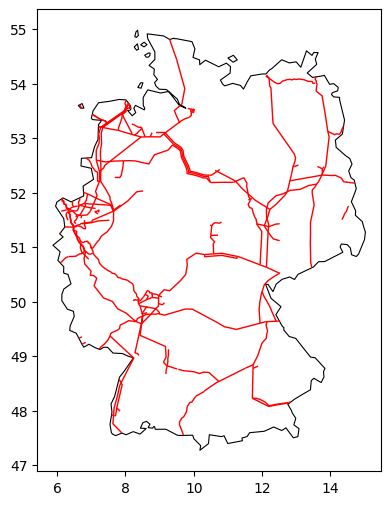

In [40]:
import geopandas as gpd
from shapely import line_interpolate_point

# 1) Read your layers
pipes = gdf.copy()                                   # your pipelines GeoDataFrame
de = DE_shape_file.copy()          # <-- path to your Germany shapefile

# 2) Harmonize CRS
if pipes.crs is None:
    pipes = pipes.set_crs("EPSG:4326")               # adjust if you know the CRS
de = de.to_crs(pipes.crs)

# 3) Single, valid Germany polygon
de_union = de.dissolve().buffer(0)                   # dissolve + fix minor geometry issues

# 4) Clip pipelines to Germany
pipes_de = gpd.clip(pipes, de_union)

# 5) Plot (quick check)
ax = de_union.plot(color="none", figsize=(6,6), linewidth=0.8)
pipes_de.plot(ax=ax, color="red", linewidth=1)
#ax.set_axis_off()


# 6) Save if needed
# pipes_de.to_file("pipelines_germany.shp")                      # Shapefile
# pipes_de.to_file("pipelines.gpkg", layer="pipelines_DE", driver="GPKG")  # GeoPackage


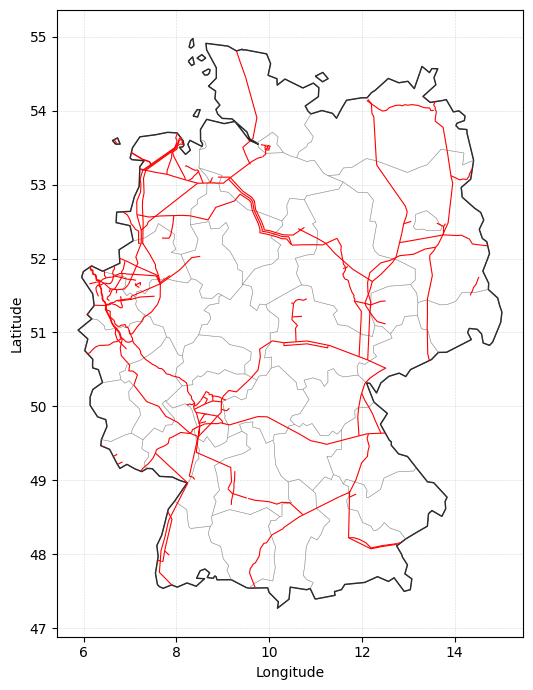

In [61]:
import geopandas as gpd
import matplotlib.pyplot as plt

# make layers
nuts2 = DE_shape_file.to_crs("EPSG:4326")
outer = nuts2.dissolve().boundary  # single outer boundary
inner = nuts2.boundary             # all region edges

fig, ax = plt.subplots(figsize=(6,7))
# control styles independently:
outer.plot(ax=ax, edgecolor="black", linewidth=1)      # outer DE border
inner.plot(ax=ax, edgecolor="grey",  linewidth=0.4, alpha=0.6)  # NUTS-2
pipes_de.plot(ax=ax, color="red", linewidth=.8)

ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude"); ax.grid(True, ls="--", lw=0.4, alpha=0.5)
plt.tight_layout(); plt.show()




In [62]:
# See all attribute columns (excluding geometry)
print(pipes_de.columns)

# Quick look at the non-geometry attributes
print(pipes_de.drop(columns="geometry").head())

# Save attributes to a table (CSV/Excel)
pipes_de.drop(columns="geometry").to_csv("pipelines_in_DE.csv", index=False)

# If you want specific fields only
descriptions = pipes_de[["OBJECTID", "Project_Na", "Commission", "Peak_Incre"]]
descriptions.head()
#descriptions.to_clipboard()


Index(['OBJECTID', 'Project_Na', 'Commission', 'Peak_Incre', 'geometry'], dtype='object')
     OBJECTID                                         Project_Na Commission  \
638       102                                 Alpine H2 Corridor       2035   
715       192                         RHYn Interco (Section 4-5)       2035   
708       185                                       Alpine HyWay       2040   
669       143                  HyPipe Bavaria - The Hydrogen Hub       2030   
746       224  FLOW – making hydrogen happen (West) - Connect...       2030   

            Peak_Incre  
638  No data available  
715  No data available  
708  No data available  
669                150  
746                480  


,OBJECTID,Project_Na,Commission,Peak_Incre
638,102,Alpine H2 Corridor,2035,No data available
715,192,RHYn Interco (Section 4-5),2035,No data available
708,185,Alpine HyWay,2040,No data available
669,143,HyPipe Bavaria - The Hydrogen Hub,2030,150
746,224,FLOW – making hydrogen happen (West) - Connect...,2030,480


## demand

In [77]:
all_layer_data_df.fillna("unknown", inplace=True)
demand_df = all_layer_data_df[(all_layer_data_df._layer_name.str.contains('|Demand And Production|') & (all_layer_data_df.Project_Type.str.contains('Demand')))]  
#mask_geom = all_layer_data_df["geometry"].astype(str).str.contains("paths", case=False, na=False)
#pipelines_df = all_layer_data_df.loc[mask_geom].copy()
demand_df.head()#.to_clipboard()

,OBJECTID,Project_Na,Promoter_N,Project_Ty,Category,Commission,Share_of_t,Location,Increment,Peak_Incre,...,Daily_Send_out_capacity__GWh,Total_storage_capacity__GWh,Maturity_S,Operation,Storage_Ty,Storage_wo,Injection,Withdrawal,NAME,Shape__Length
74,23,unknown,unknown,unknown,unknown,unknown,unknown,"Austria, Southern Germany, CEE region",unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
94,45,unknown,unknown,unknown,unknown,unknown,unknown,Duisburg,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
102,53,unknown,unknown,unknown,unknown,unknown,unknown,Duisburg,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
103,54,unknown,unknown,unknown,unknown,unknown,unknown,Duisburg,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
112,63,unknown,unknown,unknown,unknown,unknown,unknown,No data available,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown


In [78]:
demand_df = demand_df[['OBJECTID', 'Project_Na', 'Commission', 'Peak_Incre', 'geometry', 'Production_category', 'Project_Type']]
#print(pipelines_df.geometry)
demand_df.head()

,OBJECTID,Project_Na,Commission,Peak_Incre,geometry,Production_category,Project_Type
74,23,unknown,unknown,unknown,"{'x': 12.774745307000048, 'y': 48.14353899800003}",No data available,Demand
94,45,unknown,unknown,unknown,"{'x': 6.8555234790001025, 'y': 51.373283947000...",No data available,Demand
102,53,unknown,unknown,unknown,"{'x': 6.771540666000019, 'y': 51.40761897700008}",No data available,Demand
103,54,unknown,unknown,unknown,"{'x': 6.693349770000044, 'y': 51.360627704000066}",No data available,Demand
112,63,unknown,unknown,unknown,"{'x': 5.400000000000065, 'y': 45.82000000000005}",No data available,Demand


In [86]:
import json, ast, re, geopandas as gpd
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString
from shapely import wkt
import numpy as np
import pandas as pd

def to_geom_any(val):
    # already shapely
    if hasattr(val, "geom_type"): return val

    # WKT
    if isinstance(val, str) and re.match(r'^\s*(MULTI)?(POINT|LINESTRING)', val, re.I):
        try: return wkt.loads(val)
        except: return None

    # JSON / python dict
    g = val
    if isinstance(g, str):
        s = g.strip()
        try: g = json.loads(s)
        except:
            try: g = ast.literal_eval(s)
            except: return None

    if isinstance(g, dict):
        t = g.get("type", "").lower()
        if t == "point":
            x, y = g.get("coordinates", [None, None])[:2]
            return Point(x, y) if (x is not None and y is not None) else None
        if t == "multipoint":
            coords = [(x, y) for x, y, *rest in g.get("coordinates", [])]
            return MultiPoint(coords) if coords else None
        if t == "linestring":
            coords = [(x, y) for x, y, *rest in g.get("coordinates", [])]
            return LineString(coords) if len(coords) >= 2 else None
        if t == "multilinestring":
            lines = []
            for seg in g.get("coordinates", []):
                coords = [(x, y) for x, y, *rest in seg]
                if len(coords) >= 2: lines.append(LineString(coords))
            return MultiLineString(lines) if lines else None

        # ESRI
        if "x" in g and "y" in g:
            return Point(g["x"], g["y"])
        if any(k in g for k in ("paths","Paths","PATHS")):
            paths = g.get("paths") or g.get("Paths") or g.get("PATHS")
            lines = []
            for path in paths:
                coords = [(x, y) for x, y, *rest in path]
                if len(coords) >= 2: lines.append(LineString(coords))
            if lines:
                return lines[0] if len(lines)==1 else MultiLineString(lines)

    return None

# ---- Build point GeoDataFrame ----
df = demand_df.copy()

# If you have lon/lat columns, prefer them (replace names if different)
lon_col, lat_col = None, None
for c in df.columns:
    lc = c.lower()
    if lc in ("lon","longitude","x"): lon_col = lon_col or c
    if lc in ("lat","latitude","y"):  lat_col = lat_col or c

if lon_col and lat_col:
    gdf_demand_points = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col].astype(float), df[lat_col].astype(float)),
        crs="EPSG:4326"
    )
else:
    GEOM_COL = "geometry"  # adjust if your geometry string lives elsewhere
    df["geometry"] = df[GEOM_COL].apply(to_geom_any)
    gdf_demand_points = gpd.GeoDataFrame(df[df["geometry"].notna()].copy(), geometry="geometry", crs="EPSG:4326")

print("Parsed point features:", len(gdf_demand_points))


Parsed point features: 31


<Axes: >

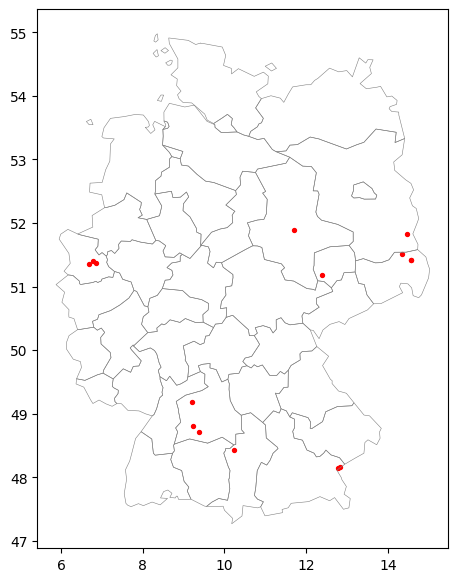

In [87]:
# clip to Germany if needed
nuts2 = DE_shape_file.to_crs("EPSG:4326")
de_union = nuts2.dissolve().buffer(0)
pts_de = gpd.clip(gdf_demand_points, de_union)

ax = nuts2.boundary.plot(figsize=(6,7), edgecolor="grey", linewidth=0.4)
pts_de.plot(ax=ax, markersize=8, color="red")


## production

In [84]:
all_layer_data_df.fillna("unknown", inplace=True)
production_df = all_layer_data_df[(all_layer_data_df._layer_name.str.contains('|Demand And Production|') & (all_layer_data_df.Project_Type.str.contains('Production')))]  
#mask_geom = all_layer_data_df["geometry"].astype(str).str.contains("paths", case=False, na=False)
#pipelines_df = all_layer_data_df.loc[mask_geom].copy()
production_df.head()#.to_clipboard()

,OBJECTID,Project_Na,Promoter_N,Project_Ty,Category,Commission,Share_of_t,Location,Increment,Peak_Incre,...,Daily_Send_out_capacity__GWh,Total_storage_capacity__GWh,Maturity_S,Operation,Storage_Ty,Storage_wo,Injection,Withdrawal,NAME,Shape__Length
52,1,unknown,unknown,unknown,unknown,unknown,unknown,No data available,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
53,2,unknown,unknown,unknown,unknown,unknown,unknown,Enna,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
54,3,unknown,unknown,unknown,unknown,unknown,unknown,Taranto,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
55,4,unknown,unknown,unknown,unknown,unknown,unknown,Kardoskut,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
56,5,unknown,unknown,unknown,unknown,unknown,unknown,No data available,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown


In [85]:
production_df = production_df[['OBJECTID', 'Project_Na', 'Commission', 'Peak_Incre', 'geometry', 'Production_category', 'Project_Type']]
#print(pipelines_df.geometry)
production_df.head()

,OBJECTID,Project_Na,Commission,Peak_Incre,geometry,Production_category,Project_Type
52,1,unknown,unknown,unknown,"{'x': 4.413687881000034, 'y': 54.75475413000005}",Electrolyser,Production
53,2,unknown,unknown,unknown,"{'x': 14.779700000000053, 'y': 37.50500000000005}",Electrolyser,Production
54,3,unknown,unknown,unknown,"{'x': 17.245865810000065, 'y': 40.46647570000012}",Electrolyser,Production
55,4,unknown,unknown,unknown,"{'x': 20.797837330000053, 'y': 46.49742475000005}",Electrolyser,Production
56,5,unknown,unknown,unknown,"{'x': 12.545823160000074, 'y': 51.41633197000005}",Methane Reforming (SMR/ATR),Production


In [89]:
import json, ast, re, geopandas as gpd
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString
from shapely import wkt
import numpy as np
import pandas as pd

def to_geom_any(val):
    # already shapely
    if hasattr(val, "geom_type"): return val

    # WKT
    if isinstance(val, str) and re.match(r'^\s*(MULTI)?(POINT|LINESTRING)', val, re.I):
        try: return wkt.loads(val)
        except: return None

    # JSON / python dict
    g = val
    if isinstance(g, str):
        s = g.strip()
        try: g = json.loads(s)
        except:
            try: g = ast.literal_eval(s)
            except: return None

    if isinstance(g, dict):
        t = g.get("type", "").lower()
        if t == "point":
            x, y = g.get("coordinates", [None, None])[:2]
            return Point(x, y) if (x is not None and y is not None) else None
        if t == "multipoint":
            coords = [(x, y) for x, y, *rest in g.get("coordinates", [])]
            return MultiPoint(coords) if coords else None
        if t == "linestring":
            coords = [(x, y) for x, y, *rest in g.get("coordinates", [])]
            return LineString(coords) if len(coords) >= 2 else None
        if t == "multilinestring":
            lines = []
            for seg in g.get("coordinates", []):
                coords = [(x, y) for x, y, *rest in seg]
                if len(coords) >= 2: lines.append(LineString(coords))
            return MultiLineString(lines) if lines else None

        # ESRI
        if "x" in g and "y" in g:
            return Point(g["x"], g["y"])
        if any(k in g for k in ("paths","Paths","PATHS")):
            paths = g.get("paths") or g.get("Paths") or g.get("PATHS")
            lines = []
            for path in paths:
                coords = [(x, y) for x, y, *rest in path]
                if len(coords) >= 2: lines.append(LineString(coords))
            if lines:
                return lines[0] if len(lines)==1 else MultiLineString(lines)

    return None

# ---- Build point GeoDataFrame ----
df = production_df.copy()

# If you have lon/lat columns, prefer them (replace names if different)
lon_col, lat_col = None, None
for c in df.columns:
    lc = c.lower()
    if lc in ("lon","longitude","x"): lon_col = lon_col or c
    if lc in ("lat","latitude","y"):  lat_col = lat_col or c

if lon_col and lat_col:
    gdf_production_points = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col].astype(float), df[lat_col].astype(float)),
        crs="EPSG:4326"
    )
else:
    GEOM_COL = "geometry"  # adjust if your geometry string lives elsewhere
    df["geometry"] = df[GEOM_COL].apply(to_geom_any)
    gdf_production_points = gpd.GeoDataFrame(df[df["geometry"].notna()].copy(), geometry="geometry", crs="EPSG:4326")

print("Parsed point features:", len(gdf_production_points))


Parsed point features: 249


<Axes: >

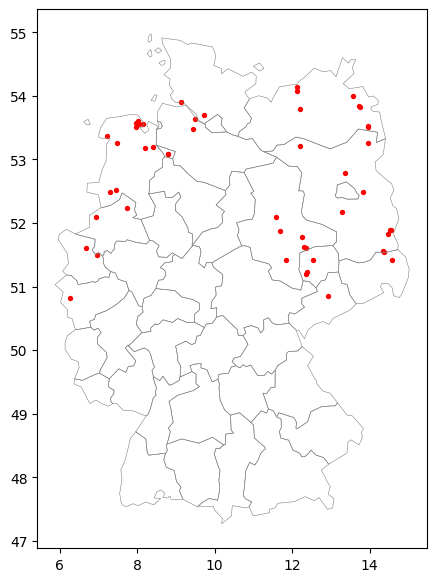

In [90]:
# clip to Germany if needed
nuts2 = DE_shape_file.to_crs("EPSG:4326")
de_union = nuts2.dissolve().buffer(0)
pts_de = gpd.clip(gdf_production_points, de_union)

ax = nuts2.boundary.plot(figsize=(6,7), edgecolor="grey", linewidth=0.4)
pts_de.plot(ax=ax, markersize=8, color="red")
